In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
#from tensorflow.keras.callbacks import  ModelCheckpoint
from tensorflow.keras.backend import square, mean

In [3]:
import weather

In [4]:
tf.__version__

'2.1.0'

In [5]:
tf.keras.__version__

'2.2.4-tf'

In [6]:
pd.__version__

'1.1.0'

In [7]:
weather.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [8]:
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

In [9]:

%%time
df = weather.load_resampled_data()

Wall time: 236 ms


In [10]:
df.head()

Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      NaN   
1980-03-01 12:00:00  1008.600000      13.4   280.0  6.583333      NaN   
1980-03-01 13:00:00  1008.433333      15.4   280.0  6.888889      NaN   
1980-03-01 14:00:00  1008.266667      14.9   300.0  6.222222      NaN   
1980-03-01 15:00:00  1008.100000      17.0   290.0  5.555556      NaN   

                                              Odense                          \
                     WindSpeed     WindDir      Temp     Pressure  WindSpeed   
DateTime                                                                       
1980-03-01 11:00:00  12.383333  310.000000  6.142857  1011.066667  12.585714   
1980-03-01 12:00:00  12.883333  310.000000  7.000000  1011.200000  11.300000   
1980-03-01 13:00:00  13.244444  309.444444  7.000000  1011.300000  12.118182   
1980-03-01 14:00:00  12.911111  306.111111  6.857143  1011.400000  12.742857   
1980-03-01 15:00:00  12.577778  302.777778  6.000000  1011.500000  12.400000   

                             Roskilde                                  
                    WindDir      Temp Pressure  WindSpeed     WindDir  
DateTime                                                               
1980-03-01 11:00:00   290.0  5.000000      NaN  11.466667  280.000000  
1980-03-01 12:00:00   290.0  5.000000      NaN  12.466667  280.000000  
1980-03-01 13:00:00   290.0  5.166667      NaN  13.133333  278.333333  
1980-03-01 14:00:00   290.0  5.833333      NaN  12.300000  270.000000  
1980-03-01 15:00:00   290.0  4.833333      NaN  12.300000  270.000000

# Missing Data

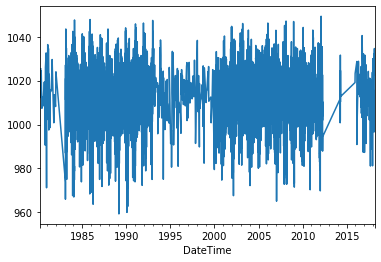

In [11]:
df['Esbjerg']['Pressure'].plot();

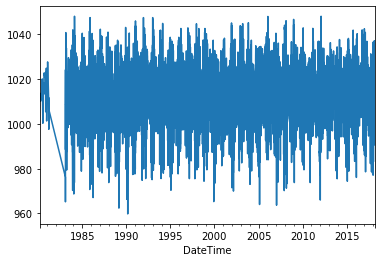

In [12]:
df['Roskilde']['Pressure'].plot();

In [13]:

df.values.shape

(333109, 20)

In [14]:
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

In [15]:
df.values.shape

(333109, 18)

In [16]:

df.head(1)

Aalborg                                Aarhus           \
                       Temp     Pressure WindSpeed WindDir   Temp Pressure   
DateTime                                                                     
1980-03-01 11:00:00     5.0  1007.766667      10.2   280.0    5.0   1008.3   

                                        Esbjerg                       Odense  \
                    WindSpeed WindDir      Temp  WindSpeed WindDir      Temp   
DateTime                                                                       
1980-03-01 11:00:00      15.4   290.0  6.083333  12.383333   310.0  6.142857   

                                                    Roskilde             \
                        Pressure  WindSpeed WindDir     Temp  WindSpeed   
DateTime                                                                  
1980-03-01 11:00:00  1011.066667  12.585714   290.0      5.0  11.466667   

                             
                    WindDir  
DateTime                     
1980-03-01 11:00:00   280.0

### Data Errors

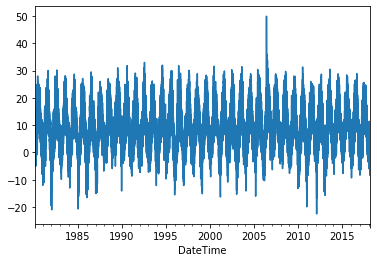

In [17]:
df['Odense']['Temp'].plot();
#df['Odense']['Temp']['2006-05':'2006-07'].plot();

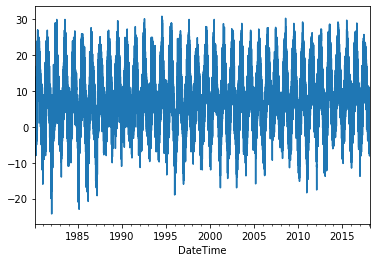

In [18]:
df['Aarhus']['Temp'].plot();

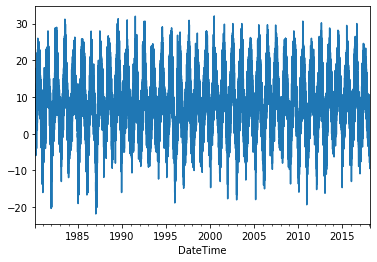

In [19]:
df['Roskilde']['Temp'].plot();

df['Roskilde']['Temp']['2006-05':'2006-07'].plot();

In [20]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour


### Target Data for Prediction

In [21]:

target_city = 'Odense'

In [22]:
target_names = ['Temp', 'WindSpeed', 'Pressure']

In [23]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

In [24]:
df_targets = df[target_city][target_names].shift(-shift_steps)

In [25]:
df[target_city][target_names].head(shift_steps + 5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,6.142857,12.585714,1011.066667
1980-03-01 12:00:00,7.000000,11.300000,1011.200000
1980-03-01 13:00:00,7.000000,12.118182,1011.300000
1980-03-01 14:00:00,6.857143,12.742857,1011.400000
1980-03-01 15:00:00,6.000000,12.400000,1011.500000
1980-03-01 16:00:00,4.909091,12.618182,1011.688889
1980-03-01 17:00:00,3.953488,12.646512,1011.877778
1980-03-01 18:00:00,3.674419,11.725581,1012.066667
1980-03-01 19:00:00,3.395349,10.804651,1012.255556


In [26]:
df_targets.head(5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,6.828571,1005.833333
1980-03-01 12:00:00,2.000000,8.200000,1005.200000
1980-03-01 13:00:00,0.166667,9.216667,1004.766667
1980-03-01 14:00:00,1.000000,11.885714,1004.333333
1980-03-01 15:00:00,1.000000,12.400000,1003.900000


In [27]:
df_targets.tail()

,Temp,WindSpeed,Pressure
DateTime,,,
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN
2018-03-01 22:00:00,NaN,NaN,NaN
2018-03-01 23:00:00,NaN,NaN,NaN


### NumPy Arrays

In [28]:
x_data = df.values[0:-shift_steps]

In [29]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 20)


In [30]:
y_data = df_targets.values[:-shift_steps]

In [31]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 3)


In [32]:
num_data = len(x_data)
num_data

333085

In [33]:
train_split = 0.9

In [34]:
num_train = int(train_split * num_data)
num_train

299776

In [35]:
num_test = num_data - num_train
num_test

33309

In [36]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

333085

In [37]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

333085

In [38]:
num_x_signals = x_data.shape[1]
num_x_signals

20

In [39]:
num_y_signals = y_data.shape[1]
num_y_signals

3

In [40]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -27.0
Max: 1050.8


In [41]:
x_scaler = MinMaxScaler()

In [42]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [43]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [44]:
x_test_scaled = x_scaler.transform(x_test)

In [45]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [46]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 20)
(299776, 3)


In [47]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [48]:
batch_size = 256

In [49]:
sequence_length = 24 * 7 * 8
sequence_length

1344

In [50]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [51]:
x_batch, y_batch = next(generator)

In [52]:
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


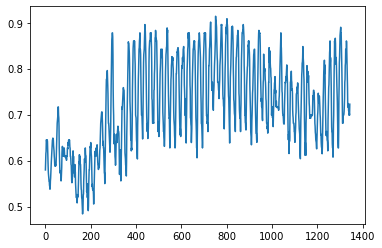

In [53]:

batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

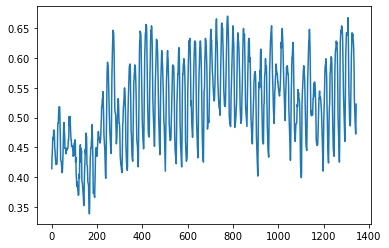

In [54]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [55]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [56]:

model = Sequential()

In [57]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [58]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [59]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [60]:
warmup_steps = 50

In [61]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [62]:
optimizer = RMSprop(lr=1e-3)

In [63]:

model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [64]:
model.save("Wether.h5")

In [65]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         820224    
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 821,763
Trainable params: 821,763
Non-trainable params: 0
_________________________________________________________________


In [66]:
import os.path
#checkpoint_path = "D:/TF2/Time_Series_RNN_TF/Wether.h5"

checkpoint_path = os.path.join("D:/TF2/Time_Series_RNN_TF","Wether.h5")
checkpoint_dir = os.path.dirname(checkpoint_path)
#path_checkpoint ='23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [67]:
callback_early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

In [68]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/', histogram_freq=0, write_graph=False)

In [69]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',  factor=0.1,       min_lr=1e-4,    patience=0,  verbose=1)

In [70]:
callbacks = [callback_early_stopping,   callback_checkpoint,    callback_tensorboard,     callback_reduce_lr]

In [71]:
%%time
model.fit(x=generator,
          epochs=5,
          steps_per_epoch=10,
          validation_data=validation_data,
          callbacks=callbacks)

  ...
    to  
  ['...']
Train for 10 steps, validate on 1 samples
Epoch 1/5
 1/10 [==>...........................] - ETA: 1:01:00 - loss: 0.0586

ProfilerNotRunningError: Cannot stop profiling. No profiler is running.

In [72]:

try:
    model.load_weights(checkpoint_path)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [89]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 9s 9s/sample - loss: 0.0717


In [90]:
print("loss (test-set):", result)

loss (test-set): 0.07165973633527756


In [91]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [92]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

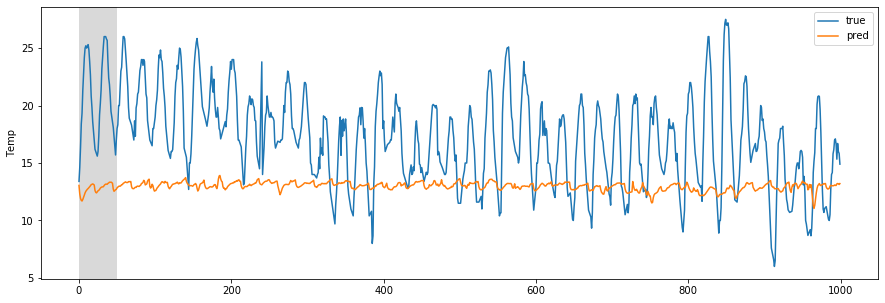

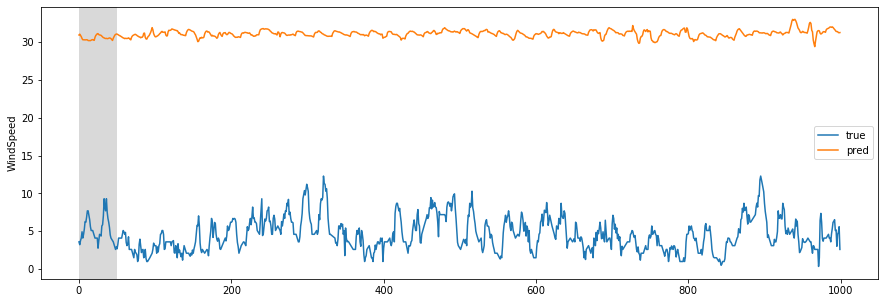

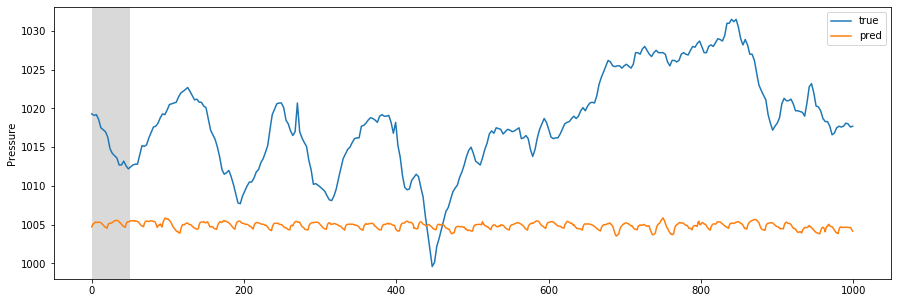

In [93]:
plot_comparison(start_idx=100000, length=1000, train=True)

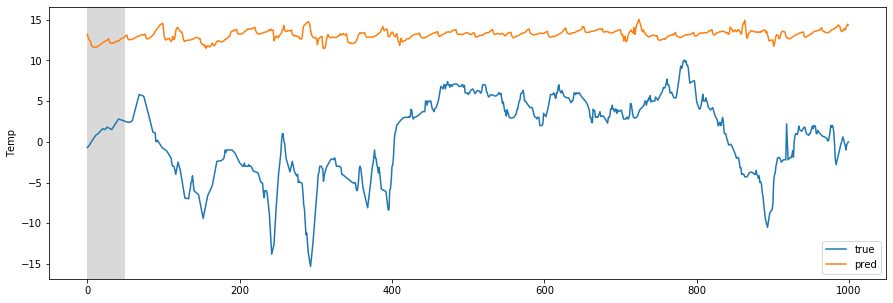

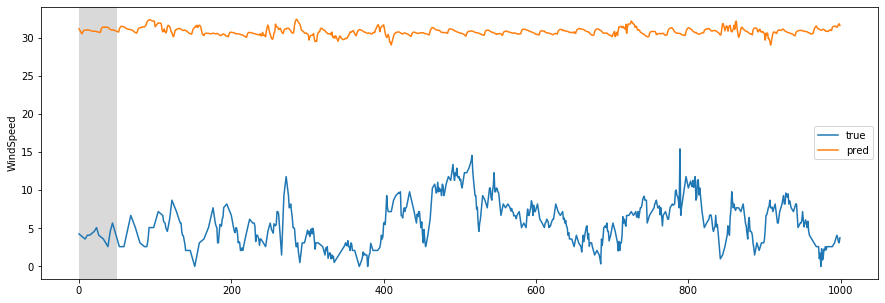

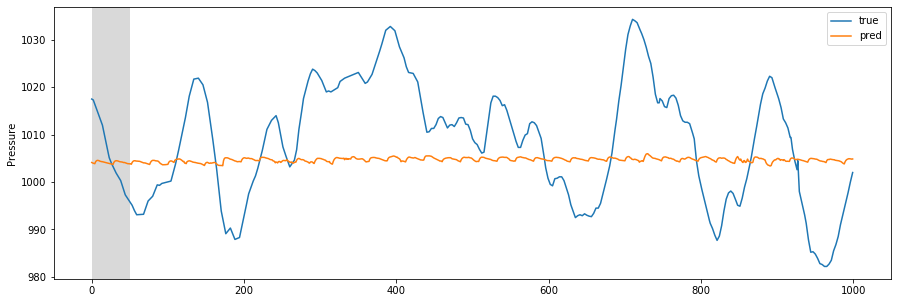

In [94]:
plot_comparison(start_idx=200000, length=1000, train=True)

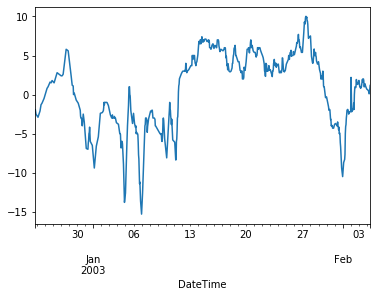

In [95]:
df['Odense']['Temp'][200000:200000+1000].plot();

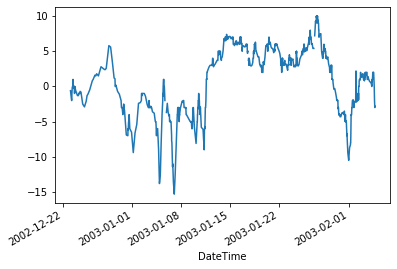

In [96]:
df_org = weather.load_original_data()
df_org.xs('Odense')['Temp']['2002-12-23':'2003-02-04'].plot();

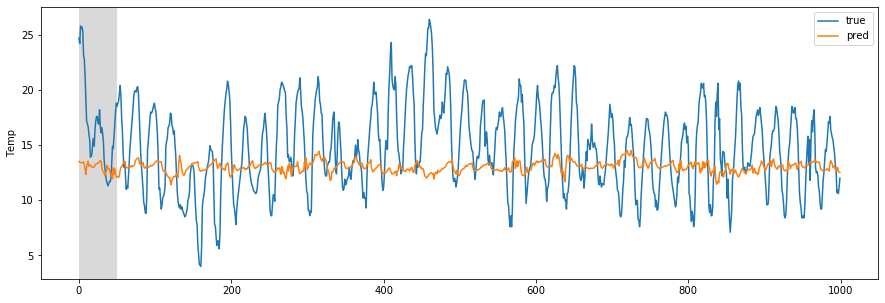

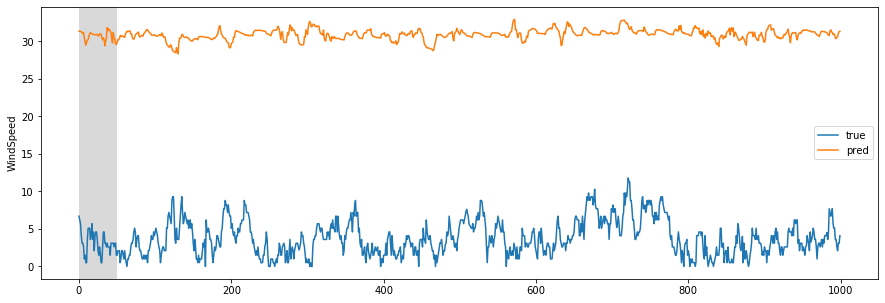

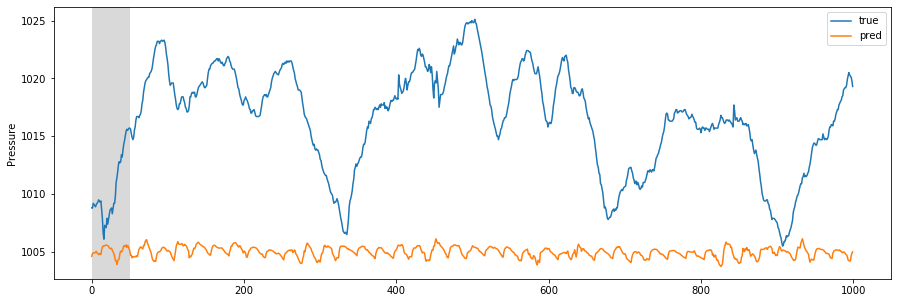

In [97]:

plot_comparison(start_idx=200, length=1000, train=False)

### Ref
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb


https://github.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/blob/master/Untitled.ipynb 



https://github.com/llSourcell/LSTM_Networks/blob/master/LSTM%20Demo.ipynb


https://github.com/llSourcell/recurrent_neural_network/blob/master/RNN.ipynb

